<a href="https://colab.research.google.com/github/anastasiiaCher/pyad-2024/blob/main/lab3/PY%D0%90%D0%94_%D0%9B%D0%A03_Explore_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

### Часть 1 (5 балла)
1. Выберите одну любую из задач, рассмотренных на [лекции](https://colab.research.google.com/drive/1B7Np_7y002NLiuNkriq6a6MchQL4Fw7p?usp=sharing) (локализация, сегментация, перенос стиля, генерация).

2. Подберите на kaggle датасет, подходящий для решения этой задачи.
  - Вариант 1: если данные обладают необходимой разметкой, то повторите пайплайн из блокнота с примером на своих данных.
  - Вариант 2: если данные не обладают необходимой разметкой, то используйте модель, которую дообучали в примере, но без дообучения.
3. Оцените и прокомментируйте результат.

### Часть 2 (8 баллов)
1. Выберите еще одну из рассмотренных в лекции задач (не совпадающую с первой).
2. Если ваши данные обладают разметкой, необходимой для новой задачи, продолжите работу с ними. Если нет, найдите другой датасет, в котором она будет. Можно взять какой-нибудь стандартный в PyTorch, но такой, который не встречался ни в одном из примеров с лекции. В этом задании обязательно нужно найти датасет с разметкой.
3. Повторите пайплайн из примера.
4. Постарайтесь улучшить качество результата (если классификация - точность выше 90%, во всех остальных - максимально понизить лосс). Это можно сделать за счет настройки гиперпараметров. Можно (опционально и в зависимости от задачи) также поменять гиперпараметры в слоях нейронных сетей и/или порядок слоев и/или их количество.

В заданиях, где перечислены два варианта выполнения, нужно выбрать только один. Выполнение обоих дополнительных баллов не дает.



# Решение

**Часть 1**

In [ ]:
!pip install yolov5

In [ ]:
!pip install -q kaggle

# Загружаем датасет Fruits-360
!kaggle datasets download -d moltean/fruits

In [ ]:
!unzip fruits.zip -d fruits

In [ ]:
import torch
import matplotlib.pyplot as plt
import cv2

# Загрузка предобученной модели YOLOv5 для классификации
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # Используем предобученную модель YOLOv5s

# Функция для отображения изображения с рамками для детекции объектов
def plot_image_with_boxes(image, predictions):
    plt.figure(figsize=(12, 12))
    plt.imshow(image[..., ::-1])  # Изменяем цветовую схему с BGR на RGB
    ax = plt.gca()

    # Проходим по всем предсказаниям
    for *box, conf, cls in predictions:  # Для каждой предсказанной рамки
        if conf > 0.4:  # Фильтрация по вероятности
            x1, y1, x2, y2 = map(int, box)  # Координаты верхнего левого и нижнего правого углов
            rect = plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,  # Рисуем прямоугольник
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

    plt.axis('off')  # Отключаем оси для улучшения отображения
    plt.show()

# Загрузка изображения
image_path = '/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2007_000187.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Детекция объектов (в данном случае классификация фруктов)
results = model(image_path)  # Модель анализирует изображение
results.print()

# Получаем предсказания для отображения (тензор с результатами)
predictions = results.xywh[0].cpu().numpy()  # Переход в numpy для удобной работы

# Отображаем изображение с рамками, если объекты были найдены
plot_image_with_boxes(image_rgb, predictions)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-25 Python-3.11.11 torch-2.5.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 375x500 1 tv, 1 mouse, 1 keyboard
Speed: 9.9ms pre-process, 399.2ms inference, 1.8ms NMS per image at shape (1, 3, 480, 640)


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-7cefos8x
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-7cefos8x
  Resolved https://github.com/albumentations-team/albumentations to commit 798e7291c3bee535694122434e5670cb2c789b81
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np

# Устанавливаем аугментации с Albumentations
transform = A.Compose([
    A.Resize(640, 640),  # Приводим изображения к размеру 640x640
    A.RandomBrightnessContrast(p=0.5),  # Меняем яркость и контраст
    A.HueSaturationValue(p=0.5),  # Модифицируем оттенки
])

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

def plot_image_with_boxes(image, predictions):
    plt.figure(figsize=(12, 12))
    plt.imshow(image[..., ::-1])
    ax = plt.gca()


    for *box, conf, cls in predictions:
        if conf > 0.4:
            x1, y1, x2, y2 = map(int, box)
            rect = plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

    plt.axis('off')
    plt.show()

image_path = '/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2007_000187.jpg'
image = cv2.imread(image_path)

# Применяем аугментации
augmented = transform(image=image)
augmented_image = augmented['image']

# Детекция объектов (в данном случае классификация фруктов)
results = model(augmented_image)  # Модель анализирует изображение
results.print()

# Получаем предсказания для отображения (тензор с результатами)
predictions = results.xywh[0].cpu().numpy()  # Переход в numpy для удобной работы

# Отображаем изображение с рамками, если объекты были найдены
plot_image_with_boxes(augmented_image, predictions)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-25 Python-3.11.11 torch-2.5.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 640x640 1 tv
Speed: 23.6ms pre-process, 663.0ms inference, 3.3ms NMS per image at shape (1, 3, 640, 640)


**Улучшим код**:

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import matplotlib.pyplot as plt

# Класс для обработки датасета
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]  # Формирование списка путей

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Попробуем загрузить изображение
        image = cv2.imread(img_path)

        # Проверка, что изображение было загружено
        if image is None:
            print(f"Warning: Не удалось загрузить изображение {img_path}")
            return None  # Если не удалось загрузить, возвращаем None (можно также возвращать пустое изображение или другое значение)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертируем BGR в RGB

        if self.transform:
            augmented = self.transform(image=image_rgb)  # Применяем аугментацию
            image_rgb = augmented['image']

        return image_rgb

# Преобразования изображений для аугментации
transform = A.Compose([
    A.Resize(640, 640),  # Приводим изображение к размеру 640x640
    A.RandomBrightnessContrast(p=0.5),  # Изменение яркости и контраста
    A.HueSaturationValue(p=0.5),  # Модификация оттенков
])

# Загрузка данных
train_dataset = CustomDataset('/content/fruits/fruits-360_dataset_100x100/fruits-360/Training/Quince', transform=transform)
test_dataset = CustomDataset('/content/fruits/fruits-360_dataset_100x100/fruits-360/Test/Quince', transform=transform)

# Убедимся, что каждый батч имеет допустимые изображения
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Проверка загрузки изображений и печать их размера
for images in train_loader:
    if images is None:
        continue  # Пропустим батч, если изображения в нем отсутствуют
    print(images.shape)  # Печатаем размеры изображений

# Если изображения загружены, давайте отобразим одно из них
sample_image = next(iter(train_loader))  # Берем один батч
if sample_image is not None:
    # Преобразуем тензор из формата (C, H, W) в формат (H, W, C)
    image_to_show = sample_image[0].permute(1, 2, 0).numpy()  # Переставляем оси
    plt.imshow(image_to_show)
    plt.show()

torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([32, 640, 640, 3])
torch.Size([10, 640, 640, 3])


TypeError: Invalid shape (640, 3, 640) for image data

# Переделывание задания

In [ ]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image

# Путь к данным VOC 2012
path_to_data = Path('/content/path_to_data/VOCdevkit/VOC2012')

# Путь к файлу с аннотациями для категории "bicycle" (обучающий набор)
bicycle_annotations = path_to_data / 'ImageSets' / 'Main' / 'bicycle_train.txt'

# Чтение файла с метками
with open(bicycle_annotations, 'r') as f:
    image_ids = f.read().splitlines()

# Путь к изображениям
image_folder = path_to_data / 'JPEGImages'

# Получение путей к изображениям, которые относятся к категории "bicycle"
image_paths = [image_folder / f'{image_id}.jpg' for image_id in image_ids]

# Разделение данных на обучающие и валидационные
train_paths, val_paths = train_test_split(image_paths, test_size=0.2)

# Пример вывода нескольких путей
print(f'Пример путей к изображениям для тренировки: {train_paths[:5]}')
print(f'Пример путей к изображениям для валидации: {val_paths[:5]}')

Пример путей к изображениям для тренировки: [PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2008_000227 -1.jpg'), PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2010_004163 -1.jpg'), PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2008_007039 -1.jpg'), PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2008_008180 -1.jpg'), PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2010_001596 -1.jpg')]
Пример путей к изображениям для валидации: [PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2008_002966 -1.jpg'), PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2010_001418 -1.jpg'), PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2009_002845 -1.jpg'), PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2009_003519  1.jpg'), PosixPath('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2008_005905 -1.jpg')]


In [ ]:
# Модель для классификации или локализации
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Преобразования для предобработки изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Класс Dataset для загрузки изображений
class VOC2012Dataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Подготовка DataLoader для train и val
train_dataset = VOC2012Dataset(train_paths, transform)
val_dataset = VOC2012Dataset(val_paths, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Загрузка предобученной модели ResNet для классификации
model = models.resnet18(pretrained=True)

# Модификация последнего слоя для 2 классов (например, "bicycle" или "not bicycle")
model.fc = torch.nn.Linear(model.fc.in_features, 2)

# Перенос модели на устройство (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция потерь
criterion = torch.nn.CrossEntropyLoss()

# Обучение модели
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs in train_loader:
        inputs = inputs.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs)

        # Для задачи классификации предполагаем 2 класса: велосипед/не велосипед
        labels = torch.zeros(inputs.size(0), dtype=torch.long).to(device)  # Пример: все метки = 0 (не велосипед)
        labels[0] = 1  # Пример: метка для первого изображения = 1 (велосипед)

        loss = criterion(outputs, labels)

        # Обратный проход и обновление весов
        loss.backward()
        optimizer.step()

        # Статистика
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct/total}%")

FileNotFoundError: [Errno 2] No such file or directory: '/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2011_002618 -1.jpg'

Часть 2: Сегментация

In [ ]:
pip install kagglehub

In [ ]:
import kagglehub

# Загрузка последней версии датасета
path = kagglehub.dataset_download("awsaf49/ade20k-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.10G/1.10G [00:24<00:00, 48.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/awsaf49/ade20k-dataset/versions/2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:05<00:00, 40.9MB/s]


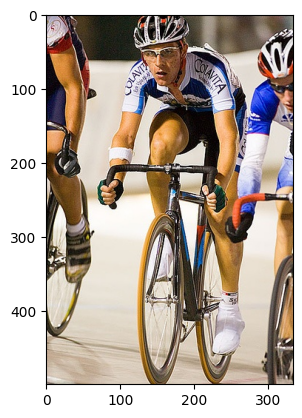

In [ ]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image  # Добавляем этот импорт для работы с изображениями

# Загружаем предобученную модель DeepLabV3+
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()  # Переводим модель в режим инференса

# Трансформация изображения
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Функция для отображения результата сегментации
def show_segmentation(image, output):
    output_predictions = output['out'][0].argmax(0)  # Получаем наиболее вероятные классы для каждого пикселя
    plt.imshow(output_predictions.cpu(), cmap='tab20b')
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# Пример работы с изображением
image = Image.open('/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2007_000129.jpg')
image_tensor = transform(image).unsqueeze(0)

# Инференс модели
with torch.no_grad():
    output = model(image_tensor)

# Отображаем результат
show_segmentation(image_tensor.squeeze(), output)

In [ ]:
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch import nn, optim
from PIL import Image

# Параметры
batch_size = 64
learning_rate = 0.001

# Аугментации данных для улучшения обобщающей способности
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Повороты изображений на случайный угол
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Загрузка данных CIFAR-10
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 75.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Загрузим предобученную модель ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Заменим последний слой для 10 классов

# Переводим модель в режим тренировки
model.train()

# Определим оптимизатор и критерий
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.2MB/s]


In [ ]:
# Обучение модели
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()  # Обнуляем градиенты

        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Обратный проход
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}")

Epoch 1/5, Loss: 1.0998251310852178
Epoch 2/5, Loss: 0.8380068795531607
Epoch 3/5, Loss: 0.7416056446407152
Epoch 4/5, Loss: 0.6632142111925823
Epoch 5/5, Loss: 0.6157464151797087


In [ ]:
# Оценка модели на тестовом наборе
model.eval()  # Переводим модель в режим инференса
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 79.28%


In [ ]:
# Загрузим конкретное изображение для классификации
image_path = '/content/path_to_data/VOCdevkit/VOC2012/JPEGImages/2007_002234.jpg'  # Замените на путь к своему изображению
image = Image.open(image_path)

# Преобразуем изображение с аугментациями (если необходимо)
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),  # Размер изображения, который подходит для модели
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_tensor = transform_image(image).unsqueeze(0)  # Добавляем размерность для батча

# Инференс модели
model.eval()  # Переводим модель в режим инференса
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

# Печать предсказания
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f"Predicted class: {class_names[predicted_class.item()]}")


Predicted class: deer
